In [23]:
import pandas as pd
import torch
from transformers import AutoTokenizer, AutoModel
from sklearn.metrics.pairwise import cosine_similarity
import seaborn as sns
import matplotlib.pyplot as plt

In [24]:
# Load data
rep_df = pd.read_csv("Cluster_Representative_Summaries.csv")
merged_df = pd.read_csv("Final_merged_clusters.csv")

In [25]:
# Initialize tokenizer and model
tokenizer = AutoTokenizer.from_pretrained('jinaai/jina-embeddings-v2-base-en', trust_remote_code=True)
model = AutoModel.from_pretrained(
    'jinaai/jina-embeddings-v2-base-en',
    trust_remote_code=True,
    torch_dtype=torch.float16,
    device_map='auto'
)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
if device.type != 'cuda':
    raise RuntimeError("CUDA (GPU) not available. Aborting to prevent CPU crash.")

model = model.to(device)
model.eval()

JinaBertModel(
  (embeddings): JinaBertEmbeddings(
    (word_embeddings): Embedding(30528, 768, padding_idx=0)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): JinaBertEncoder(
    (layer): ModuleList(
      (0-11): 12 x JinaBertLayer(
        (attention): JinaBertAttention(
          (self): JinaBertSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.0, inplace=False)
          )
          (output): JinaBertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
        )

In [26]:
# Mean pooling
def mean_pooling(model_output, attention_mask):
    token_embeddings = model_output[0]
    input_mask_expanded = attention_mask.unsqueeze(-1).expand(token_embeddings.size()).float()
    return (token_embeddings * input_mask_expanded).sum(1) / input_mask_expanded.sum(1)

In [27]:
# Embed text list
def embed_texts(texts):
    encoded_input = tokenizer(texts, padding=True, truncation=True, return_tensors='pt').to(device)
    with torch.no_grad():
        model_output = model(**encoded_input)
    return mean_pooling(model_output, encoded_input['attention_mask']).cpu().numpy()

In [28]:
# Embed representative summaries
rep_ids = rep_df['Cluster_ID'].astype(int).tolist()
rep_texts = rep_df['Representative_Summary'].tolist()
rep_embeddings = embed_texts(rep_texts)
cluster_to_rep_embedding = dict(zip(rep_ids, rep_embeddings))

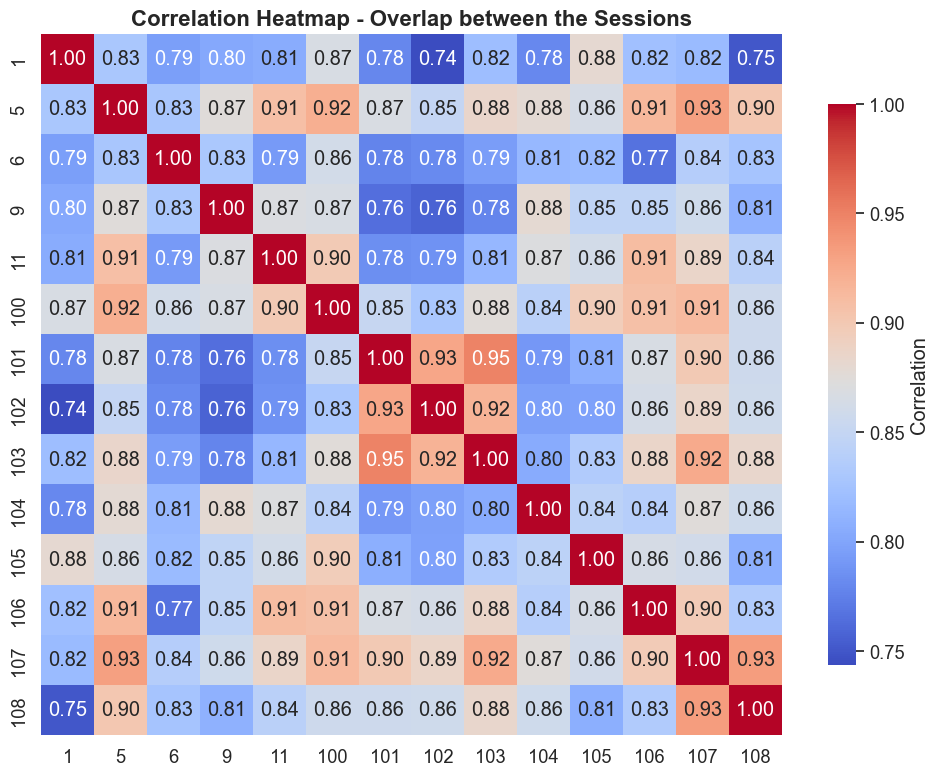

In [29]:
# Convert the dictionary to a DataFrame where rows are cluster labels and columns are vector elements
df = pd.DataFrame(cluster_to_rep_embedding)

# Compute the correlation matrix
corr_matrix = df.corr()

# Set the aesthetic style
sns.set_theme(style='white', palette='muted', font_scale=1.2)

# Create the plot
plt.figure(figsize=(10, 8))

# Use a more refined color palette and add annotations
heatmap = sns.heatmap(
    corr_matrix, 
    annot=True, 
    fmt=".2f",  # Show correlation values with two decimals
    cmap='coolwarm',  # Blue-green color map for a cleaner look
    xticklabels=df.columns, 
    yticklabels=df.columns,
    cbar_kws={'shrink': 0.8, 'label': 'Correlation'},  # Colorbar label
)

# Add a title with a larger font size
plt.title("Correlation Heatmap - Overlap between the Sessions", fontsize=16, fontweight='bold')

# Adjust the layout
plt.tight_layout()

# Show the plot
plt.show()


In [30]:
import numpy as np

ranked_cluster_summaries = {}

for cluster_id, rep_vector in cluster_to_rep_embedding.items():
    summaries = merged_df[merged_df['New_Cluster_Label'] == cluster_id]
    if summaries.empty:
        continue

    summary_ids = summaries.index.tolist()  # Use DataFrame index as ID
    summary_texts = summaries['Summary'].tolist()

    # Convert the string to actual numpy arrays
    summary_embeddings = summaries['Embedding'].apply(lambda x: np.fromstring(x.strip('[]'), sep=' ')).tolist()
        

    # Compute cosine similarity with the representative summary
    sim_scores = cosine_similarity(summary_embeddings, rep_vector.reshape(1, -1)).flatten()

    # Rank by similarity score (high to low)
    ranked = sorted(zip(summary_ids, summary_texts, sim_scores), key=lambda x: x[2], reverse=True)
    
    ranked_cluster_summaries[cluster_id] = ranked


In [31]:
import json

# Convert to a serializable format
serializable_data = {
    str(cluster_id): [
        {
            'summary_id': int(sid),
            'summary_text': text,
            'similarity_score': float(score)
        }
        for sid, text, score in summaries
    ]
    for cluster_id, summaries in ranked_cluster_summaries.items()
}

# Save to JSON file
with open('clustered_ranked_summaries.json', 'w', encoding='utf-8') as f:
    json.dump(serializable_data, f, ensure_ascii=False, indent=2)
